In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import pandas as pd
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

In [2]:
epochs = 100
learning_rate = 0.001

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [3]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/m3gofriends/My-Machine-and-Deep-Learning-Template-main/main/Data/CSV/iris.csv", 
    na_values=['NA', '?'])

In [4]:
df.head()

,sepal_l,sepal_w,petal_l,petal_w,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
# Convert to numpy - Classification
x_columns = df.columns.drop('species')
for col in x_columns:
  df[col] = zscore(df[col])

x = df[x_columns].values
dummies = pd.get_dummies(df['species']) # Classification
species = dummies.columns
y = dummies.values

In [6]:
print(x.shape)
print(y.shape)

(150, 4)
(150, 3)


In [7]:
df.head()

,sepal_l,sepal_w,petal_l,petal_w,species
0,-0.900681,1.019004,-1.340227,-1.315444,Iris-setosa
1,-1.143017,-0.131979,-1.340227,-1.315444,Iris-setosa
2,-1.385353,0.328414,-1.397064,-1.315444,Iris-setosa
3,-1.506521,0.098217,-1.283389,-1.315444,Iris-setosa
4,-1.021849,1.249201,-1.340227,-1.315444,Iris-setosa


In [8]:
# Split into train/test
x_train, y_train, x_test, y_test = train_test_split(x, y, test_size=0.2)

In [9]:
# Train
print(x_train.shape)
print(x_test.shape) # Label

# Test
print(y_train.shape)
print(y_test.shape) # Label

(120, 4)
(120, 3)
(30, 4)
(30, 3)


In [10]:
x_train = torch.Tensor(x_train).cuda()
x_test = torch.Tensor(x_test).cuda()
y_train = torch.Tensor(y_train).cuda()
y_test = torch.Tensor(y_test).cuda()
y_test = y_test.data.max(1, keepdim=True)[1]

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [12]:
network = Net()
network.cuda()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [13]:
train_losses = []
train_counter = []
test_accuracy = []

In [14]:
def train(epoch):
  network.train()
  optimizer.zero_grad()
  pred = network(x_train)
  loss = F.cross_entropy(pred, x_test)
  loss.backward()
  torch.nn.utils.clip_grad_norm_(network.parameters(), 5)
  optimizer.step()

  print('Train Epoch : {}, Loss : {:.6f}'.format(epoch, loss.item()))
  train_losses.append(loss.item())
  train_counter.append(epoch)

In [15]:
def test(epoch):
  correct = 0
  network.eval()
  with torch.no_grad():
    result = network(y_train)
  result = result.data.max(1, keepdim=True)[1]
  correct=torch.eq(result, y_test).sum().item()

  print('Test Epoch : {}, Accuracy : [{}/{}] {:.1f}%'.format(epoch, correct ,len(y_test) ,100 * correct / len(y_test)))
  test_accuracy.append(100 * correct / len(y_test))

In [16]:
for epoch in range(epochs):
  train(epoch)
  test(epoch)

Train Epoch : 0, Loss : 1.073453
Test Epoch : 0, Accuracy : [23/30] 76.7%
Train Epoch : 1, Loss : 1.011313
Test Epoch : 1, Accuracy : [29/30] 96.7%
Train Epoch : 2, Loss : 0.952839
Test Epoch : 2, Accuracy : [29/30] 96.7%
Train Epoch : 3, Loss : 0.885827
Test Epoch : 3, Accuracy : [29/30] 96.7%
Train Epoch : 4, Loss : 0.809885
Test Epoch : 4, Accuracy : [28/30] 93.3%
Train Epoch : 5, Loss : 0.741686
Test Epoch : 5, Accuracy : [28/30] 93.3%
Train Epoch : 6, Loss : 0.710969
Test Epoch : 6, Accuracy : [28/30] 93.3%
Train Epoch : 7, Loss : 0.660575
Test Epoch : 7, Accuracy : [28/30] 93.3%
Train Epoch : 8, Loss : 0.630176
Test Epoch : 8, Accuracy : [28/30] 93.3%
Train Epoch : 9, Loss : 0.589515
Test Epoch : 9, Accuracy : [29/30] 96.7%
Train Epoch : 10, Loss : 0.576343
Test Epoch : 10, Accuracy : [29/30] 96.7%
Train Epoch : 11, Loss : 0.519009
Test Epoch : 11, Accuracy : [29/30] 96.7%
Train Epoch : 12, Loss : 0.498948
Test Epoch : 12, Accuracy : [29/30] 96.7%
Train Epoch : 13, Loss : 0.45612

Text(0, 0.5, 'Loss')

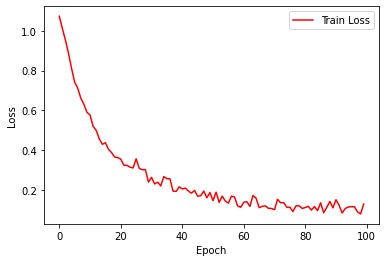

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(train_counter, train_losses, color='red')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

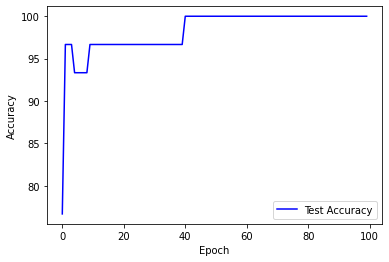

In [18]:
fig = plt.figure()
plt.plot(train_counter, test_accuracy, color='blue')
plt.legend(['Test Accuracy'], loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')